In [ ]:
# !pip install nilearn
# !pip install scikit-learn
# !pip install pandas
# !pip install numpy
# !pip install scipy
# !pip install matplotlib

In [1]:
from nilearn import datasets, image, masking, plotting, regions
from nilearn.input_data import NiftiMasker
from sklearn.decomposition import PCA
from nilearn.image import new_img_like
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import os
import pickle
import json
import math

c:\Users\david\anaconda3\envs\Brain\lib\site-packages\nilearn\input_data\__init__.py:23: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


# 1. Load and visualize data

## Text data

## FMRI human data

In [18]:
# Load a fmri file from a subjects for each language
file_path_F1 = '../FMRI/derivatives/sub-EN057/func/sub-EN057_task-lppEN_run-15_space-MNIColin27_desc-preproc_bold.nii.gz'
file_path_F2 = '../FMRI/derivatives/sub-CN002/func/sub-CN002_task-lppCN_run-04_space-MNIColin27_desc-preproc_bold.nii.gz'
file_path_F3 = '../FMRI/derivatives/sub-FR001/func/sub-FR001_task-lppFR_run-01_space-MNIColin27_desc-preproc_bold.nii.gz'
nii_img_1  = image.load_img(file_path_F1)
nii_data_EN = nii_img_1.get_fdata()
nii_img_2  = image.load_img(file_path_F2)
nii_data_CN = nii_img_2.get_fdata()
nii_img_3  = image.load_img(file_path_F3)
nii_data_FR = nii_img_3.get_fdata()

In [19]:
# units of the dimensions
print(nii_img_1.header.get_zooms())
print(nii_img_1.header.get_xyzt_units())

(2.0, 2.0, 2.0, 2.0)
('mm', 'sec')


In [4]:
# dimension size of the fmri scans for different languages
print(nii_data_EN.shape)
print(nii_data_CN.shape)
print(nii_data_FR.shape)
print('-> Voxels are the same across languages but number of timesteps differs')

(73, 90, 74, 282)
(73, 90, 74, 283)
(73, 90, 74, 309)
-> Voxels are the same across languages but number of timesteps differs


## Model representation data

In [ ]:
# Load model representations for all languages
file_path_M1 = './text_data/CN_hidden_states_chunk_size_2.pickle'
file_path_M2 = './text_data/EN_hidden_states_chunk_size_2.pickle'
file_path_M3 = './text_data/FR_hidden_states_chunk_size_2.pickle'
with open(file_path_M1, 'rb') as f:
            hidden_activations_CN = pickle.load(f)
with open(file_path_M2, 'rb') as f:
            hidden_activations_EN = pickle.load(f)
with open(file_path_M3, 'rb') as f:
            hidden_activations_FR = pickle.load(f)

In [14]:
# dimension size of the model representations for different languages
print('Dimensions: [sections, layers, chunks, max_sent_length, hidden_dim]')
print(len(hidden_activations_EN), hidden_activations_EN[0].shape)
print(len(hidden_activations_CN), hidden_activations_CN[0].shape)
print(len(hidden_activations_FR), hidden_activations_FR[0].shape)
print('-> Number of sentences/chunks is different across languages')

Dimensions: [sections, layers, chunks, max_sent_length, hidden_dim]
9 torch.Size([13, 65, 150, 768])
9 torch.Size([13, 72, 150, 768])
9 torch.Size([13, 65, 150, 768])
-> Number of sentences/chunks is different across languages


## Align model representations and FMRI scans

In [27]:
# Load text chuncks for all languages
file_path_T1 = './text_data/CN_chunk_data_chunk_size_2.pickle'
file_path_T2 = './text_data/EN_chunk_data_chunk_size_2.pickle'
file_path_T3 = './text_data/FR_chunk_data_chunk_size_2.pickle'
with open(file_path_T1, 'rb') as f:
            text_chunks_CN = pickle.load(f)
with open(file_path_T2, 'rb') as f:
            text_chunks_EN = pickle.load(f)
with open(file_path_T3, 'rb') as f:
            text_chunks_FR = pickle.load(f)

In [9]:
def text2idx(sects, delay = 5, window = 0) :
  for sect in sects :
    for sent in sect : 
      onset = int((sent['onset'] + delay - window)/2)
      offset = math.ceil((sent['offset'] + delay + window)/2)
      sent['idx'] = slice(onset, offset)
  return sects

text_bins_CN = text2idx(text_chunks_CN)
text_bins_EN = text2idx(text_chunks_EN)
text_bins_FR = text2idx(text_chunks_FR)

In [34]:
print(text_bins_EN)
print(text_bins_FR)
print(text_bins_CN)

[[{'sentences': 'once when i was six years old i saw a magnificent picture in a book about the primeval forest called real life stories. it showed a boa constrictor swallowing a wild animal. ', 'onset': 0.113, 'offset': 12.416, 'section': 1, 'idx': slice(2, 9, None)}, {'sentences': 'here is a copy of the drawing. it said in the book boa constrictors swallow their prey whole without chewing then they are not able to move and they sleep for the six months it takes for digestion. ', 'onset': 13.144, 'offset': 26.339, 'section': 1, 'idx': slice(9, 16, None)}, {'sentences': 'so i thought a lot about the adventures of the jungle and in turn i managed with a colored pencil to make my first drawing my drawing number one. it looked like this. ', 'onset': 27.292, 'offset': 38.326, 'section': 1, 'idx': slice(16, 22, None)}, {'sentences': 'i showed my masterpiece to the grownups and i asked them if my drawing frightened them. they answered me why would anyone be frightened by a hat. ', 'onset': 39

# 2. Data analysis functions

## RSA function

In [66]:
def rsa_function(file_path, data_type='FMRI', N_components=280, layer=-1, text_bins=None, interp = False, interp_size = 61):

    '''
    Compute the sen by sen RSA with cosine similarity
    '''

    if data_type == 'FMRI':

        nii_img  = image.load_img(file_path)

        if text_bins == None:

            nii_data = nii_img.get_fdata()
            time_series = nii_data.transpose(3,0,1,2).reshape(nii_data.shape[3],-1)

        else:

            # extract and mean the fmri scans for each sentence chunck
            nii_data = np.array([image.mean_img(image.index_img(nii_img_1, sent['idx'])).get_fdata() for sent in text_bins[0]])
            time_series = nii_data.reshape(nii_data.shape[0],-1)

        N_components = min(N_components, len(time_series))
        pca = PCA(N_components)
        pca.fit(time_series)
        # print('Explained variance:', pca.explained_variance_ratio_)

        data_matrix = pca.transform(time_series)

    elif data_type == 'AI':
        # Expected input: torch.Size([93, 59, 768])
        with open(file_path, 'rb') as f:
            hidden_activations = pickle.load(f)

        # input shape is [sections, layers, chunks, words, hidden_dim]
        h_a = hidden_activations[0][layer] # last hidden_activations for first section

        hidden_activations = h_a.numpy()
        data_matrix = np.mean(hidden_activations, axis=1)

    # discard first 8 seconds to account for FMRI warmup
    data_matrix = data_matrix[4:,:]
        
    if interp:
        # interpolation
        # Calculate the interpolation factor
        interp_factor = interp_size / len(data_matrix)

        # Generate indices for interpolation
        indices = np.arange(interp_size) / interp_factor

        # Perform linear interpolation
        RSA_interp = np.empty((interp_size, data_matrix.shape[1]))
        for dim in range(data_matrix.shape[1]):
            RSA_interp[:, dim] = np.interp(indices, np.arange(len(data_matrix)), data_matrix[:, dim])

        data_matrix = RSA_interp

    # compute the RSA as sentence by sentence cosine sim matrix
    RSA = sp.spatial.distance.cdist(data_matrix, data_matrix, metric='cosine')
    RSA = RSA/RSA.max()

    return RSA


## Pearson correlation function

In [12]:
def rsa_correlation(RSA_1, RSA_2):
    '''
    computes the correlation between to RSA matrizes with pearson correlation
    '''
    RSA_upper_1 = np.triu(RSA_1, 5)
    RSA_upper_2 = np.triu(RSA_2, 5)
    RSA_up_1 = RSA_upper_1[RSA_upper_1 !=0]
    RSA_up_2 = RSA_upper_2[RSA_upper_2 !=0]

    Corr = sp.stats.pearsonr(RSA_up_1.flatten(), RSA_up_2.flatten())

    return Corr

# 3. Single pair analysis

## FMRI - FMRI

In [51]:
RSA_EN_F1 = rsa_function(file_path_F1, text_bins=text_bins_EN)
RSA_CN_F1 = rsa_function(file_path_F2, text_bins=text_bins_CN, interp=True, interp_size=61)

(65, 486180)
(65, 65)
(61, 65)
(72, 486180)
(72, 72)
(68, 72)


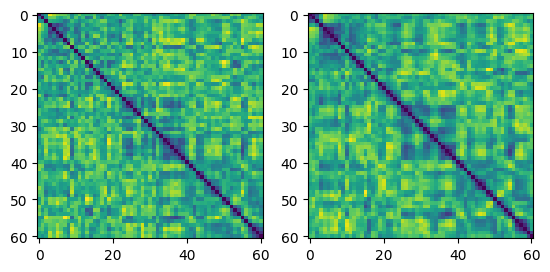

In [52]:
fig, ax = plt.subplots(1,2, figsize=(10,10))
ax[0].imshow(RSA_EN_F1)
ax[1].imshow(RSA_CN_F1)

### RSA by RSA correlation

In [53]:
Corr = rsa_correlation(RSA_EN_F1, RSA_CN_F1)
print(Corr)

PearsonRResult(statistic=0.17267906145179215, pvalue=3.775158124828832e-12)


## Model - Model

In [60]:
RSA_EN_M1 = rsa_function('./text_data/EN_hidden_states_chunk_size_2.pickle', 'AI', interp=True, interp_size=61)
RSA_CN_M1 = rsa_function('./text_data/CN_hidden_states_chunk_size_2.pickle', 'AI', interp=True, interp_size=61)

(61, 768)
(68, 768)


Text(0.5, 1.0, 'CN')

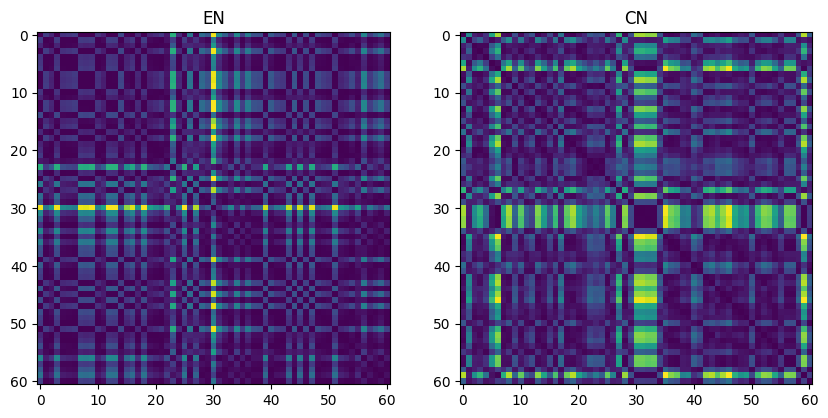

In [61]:
fig, ax = plt.subplots(1,2, figsize=(10,10))
ax[0].imshow(RSA_EN_M1)
ax[0].set_title('EN')
ax[1].imshow(RSA_CN_M1)
ax[1].set_title('CN')

In [62]:
# pearson correlation
Corr_EN_CN = rsa_correlation(RSA_EN_M1, RSA_CN_M1)

print(f'Correlation between EN and CN for last hidden represntations: {Corr_EN_CN}')

Correlation between EN and CN for last hidden represntations: PearsonRResult(statistic=0.20239677173300932, pvalue=3.239897208771371e-16)


## FMRI - Model

In [63]:
# Load a fmri file from a subjects for each language
RSA_EN_F1 = rsa_function(file_path_F1, text_bins=text_bins_EN)
RSA_EN_M1 = rsa_function('./text_data/EN_hidden_states_chunk_size_2.pickle', 'AI', interp=True, interp_size=61)

(65, 486180)
(65, 65)
(61, 65)
(61, 768)


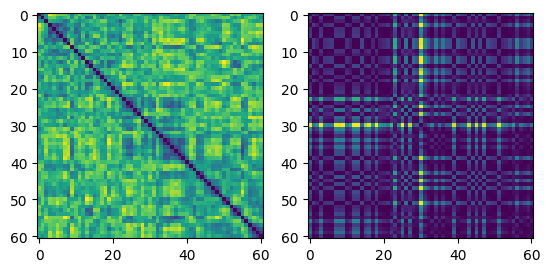

In [64]:
fig, ax = plt.subplots(1,2, figsize=(10,10))
ax[0].imshow(RSA_EN_F1)
ax[1].imshow(RSA_EN_M1)

In [65]:
Corr_F1_M1 = rsa_correlation(RSA_EN_F1, RSA_EN_M1)
print(f'Correlation between EN for last hidden represntations and EN FMRI scan: {Corr_F1_M1}')

Correlation between EN for last hidden represntations and EN FMRI scan: PearsonRResult(statistic=0.010150413438081797, pvalue=0.6853294576161205)


# 4. Analysis of all subjects

In [124]:
precompute = True

## FMRI - FMRI

### Compute the RSAs for each subject if not already available

In [68]:
if precompute == False:

    # Get the paths for the first scan for each subject
    scans = {}
    path_to_data = f'../FMRI/derivatives/'
    path_to_subjects = [it.path for it in os.scandir(path_to_data)]
    for subject_path in path_to_subjects:
        # extract name of the subject
        subject = subject_path[subject_path.find('sub-') + 4 : subject_path.find('sub-') + 9]
        # take the first scan of the subject
        path_to_scans = [it.path for it in os.scandir(subject_path + '/func/')]
        scans[subject] = path_to_scans[0]
    print(f'Number of subjects: {len(scans)}')

    # should take over an hour (appr. 40 sec per subj, n_subj=111)
    RSAs = {}
    for i, subject in enumerate(scans.keys()):
        if i % 10 == 0: print(f'Running subject {i}')
        try:
            RSAs[subject] = rsa_function(scans[subject], 'FMRI', interp=True, interp_size=61)
        except EOFError:
            print(scans[subject])
            continue

Number of subjects: 111
Running subject 0
Running subject 10
../FMRI/derivatives/sub-CN018/func/sub-CN018_task-lppCN_run-05_space-MNIColin27_desc-preproc_bold.nii.gz
../FMRI/derivatives/sub-CN019/func/sub-CN019_task-lppCN_run-05_space-MNIColin27_desc-preproc_bold.nii.gz
Running subject 20
Running subject 30
Running subject 40
Running subject 50
Running subject 60
Running subject 70
Running subject 80
Running subject 90
Running subject 100
Running subject 110


In [70]:
if precompute == False:

    RSAs_list = {}
    for key, value in RSAs.items():
        RSAs_list[key] = value.tolist()

    with open("./RSAs/RSAs_FMRI.json", "w") as f:
        json.dump(RSAs_list, f)

### Load RSAs and compute pairwise pearson correlation

In [71]:
# load the dictionary from the JSON file
with open('./RSAs/RSAs_FMRI.json', 'r') as f:
    RSAs_list = json.load(f)

# convert the nested lists back to NumPy arrays
RSAs = {}
for key, value in RSAs_list.items():
    RSAs[key] = np.array(value)

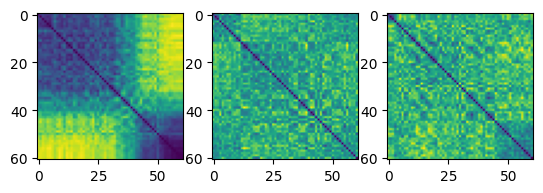

In [72]:
num_visualize = 3

count = 0
fig, ax = plt.subplots(1,num_visualize, figsize=(10,10))
for i, (key, value) in enumerate(RSAs.items()):
    ax[i].imshow(value)
    count += 1
    if count == num_visualize: break

In [73]:
N_subjects = len(scans) 
Correlations = np.zeros((N_subjects, N_subjects))
pvalues = np.zeros((N_subjects, N_subjects))
# compute pairwise correlation for all subjects
for i, subj_a in enumerate(RSAs.keys()):
    for j, subj_b in enumerate(RSAs.keys()):
        rsa_1 = RSAs[subj_a]
        rsa_2 = RSAs[subj_b]
        min_time = min(len(rsa_1), len(rsa_2))
        Correlations[i,j], pvalues[i,j] = rsa_correlation(rsa_1[:min_time, :min_time], rsa_2[:min_time, :min_time])
        print(f"Pearson correlation coefficient between {subj_a} and {subj_b}: {Correlations[i,j]}, pvalue: {pvalues[i,j]}")

Pearson correlation coefficient between CN001 and CN001: 1.0, pvalue: 0.0
Pearson correlation coefficient between CN001 and CN002: 0.0188814029670088, pvalue: 0.4509767377724463
Pearson correlation coefficient between CN001 and CN003: 0.2151425598605766, pvalue: 3.619262704412503e-18
Pearson correlation coefficient between CN001 and CN004: 0.08534612125522442, pvalue: 0.0006422074136376206
Pearson correlation coefficient between CN001 and CN005: 0.5010979382549225, pvalue: 3.281603334570479e-102
Pearson correlation coefficient between CN001 and CN006: 0.019814228223590764, pvalue: 0.4289234172457923
Pearson correlation coefficient between CN001 and CN007: 0.1046067729406436, pvalue: 2.8234818589103655e-05
Pearson correlation coefficient between CN001 and CN008: -0.0019025294691566133, pvalue: 0.9394616528362363
Pearson correlation coefficient between CN001 and CN009: 0.13465899811768045, pvalue: 6.663361400769449e-08
Pearson correlation coefficient between CN001 and CN010: 0.0787239806

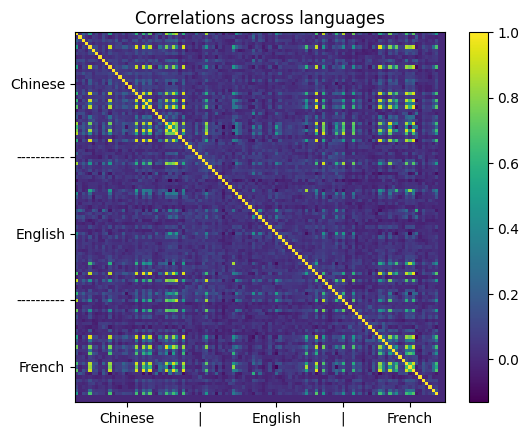

In [74]:
plt.figure(42)
plt.title('Correlations across languages')
plt.xticks([15, 37, 60 ,80, 100], ['Chinese', '|', 'English', '|', 'French'])
plt.yticks([15, 37, 60 ,80, 100], ['Chinese', '----------', 'English', '----------', 'French'])
plt.imshow(Correlations)
plt.colorbar()

## Model - Model

### Compute the RSAs for each layer and language if not already available

In [103]:
if precompute == False:

    # compute the RSAs for all languages and all layers (first section only)
    languages = ['EN','CN', 'FR']
    RSAs_models = {}
    for lang in languages:
        file_path = f'./text_data/{lang}_hidden_states_chunk_size_2.pickle'
        for layer in range(13):
            key = lang + '_' + str(layer)
            RSAs_models[key] = rsa_function(file_path, 'AI', layer=layer, interp=True, interp_size=61)

In [105]:
if precompute == False:

    RSAs_list = {}
    for key, value in RSAs_models.items():
        RSAs_list[key] = value.tolist()

    with open("./RSAs/RSAs_Model.json", "w") as f:
        json.dump(RSAs_list, f)

### Load RSAs and compute pairwise pearson correlation

In [106]:
# load the dictionary from the JSON file
with open('./RSAs/RSAs_Model.json', 'r') as f:
    RSAs_list = json.load(f)

# convert the nested lists back to NumPy arrays
RSAs_models = {}
for key, value in RSAs_list.items():
    RSAs_models[key] = np.array(value)

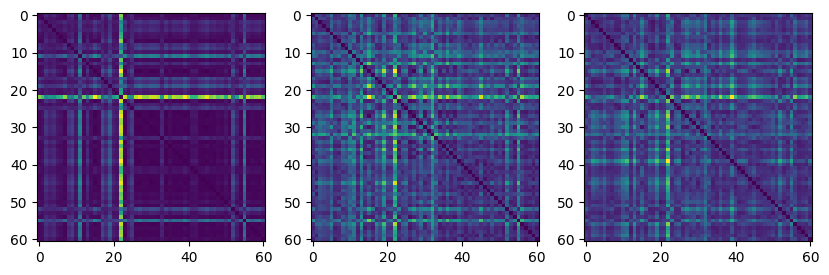

In [109]:
num_visualize = 3

count = 0
fig, ax = plt.subplots(1,num_visualize, figsize=(10,10))
for i, (key, value) in enumerate(RSAs_models.items()):
    ax[i].imshow(value)
    count += 1
    if count == num_visualize: break

In [110]:
N_RSAs = len(RSAs_models) 
Model_Correlations = np.zeros((N_RSAs, N_RSAs))
Model_pvalues = np.zeros((N_RSAs, N_RSAs))
# compute pairwise correlation for all subjects
for i, subj_a in enumerate(RSAs_models.keys()):
    for j, subj_b in enumerate(RSAs_models.keys()):
        rsa_1 = RSAs_models[subj_a]
        rsa_2 = RSAs_models[subj_b]
        Model_Correlations[i,j], Model_pvalues[i,j] = rsa_correlation(rsa_1, rsa_2)
        l1_idx = int(i / 13)
        l2_idx = int(j / 13)
        layer1_idx = i % 13
        layer2_idx = j % 13
        print(f"Pearson correlation coefficient between {languages[l1_idx]} {layer1_idx} and {languages[l2_idx]} {layer2_idx}: {Model_Correlations[i,j]}, pvalue: {Model_pvalues[i,j]}")

Pearson correlation coefficient between EN 0 and EN 0: 0.9999999999999994, pvalue: 0.0
Pearson correlation coefficient between EN 0 and EN 1: 0.6873111626077786, pvalue: 1.3876957094742759e-223
Pearson correlation coefficient between EN 0 and EN 2: 0.7103455101970234, pvalue: 2.164174790205081e-245
Pearson correlation coefficient between EN 0 and EN 3: 0.6353374913972857, pvalue: 3.711364624796617e-181
Pearson correlation coefficient between EN 0 and EN 4: 0.3642225537805175, pvalue: 2.9867769536160853e-51
Pearson correlation coefficient between EN 0 and EN 5: 0.1352365307963571, pvalue: 5.847786405291152e-08
Pearson correlation coefficient between EN 0 and EN 6: 0.09171349698374584, pvalue: 0.00024367730815845205
Pearson correlation coefficient between EN 0 and EN 7: 0.0012626357332707282, pvalue: 0.959801439330053
Pearson correlation coefficient between EN 0 and EN 8: -0.008053799417375825, pvalue: 0.7478298746648409
Pearson correlation coefficient between EN 0 and EN 9: -0.038453412

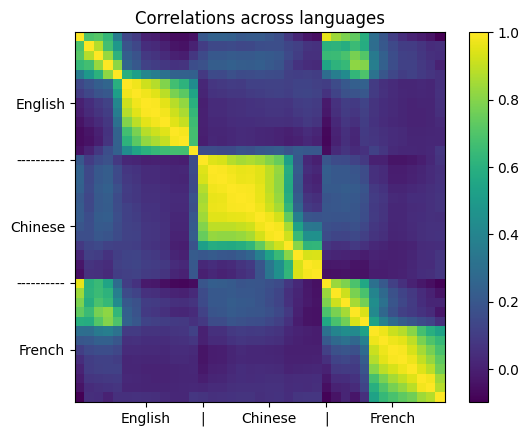

In [111]:
plt.figure(42)
plt.title('Correlations across languages')
plt.xticks([7, 13, 20, 26, 33], ['English', '|', 'Chinese', '|', 'French'])
plt.yticks([7, 13, 20, 26, 33], ['English', '----------', 'Chinese', '----------', 'French'])
plt.imshow(Model_Correlations)
plt.colorbar()

## FMRI - Model

In [112]:
# load the dictionary from the JSON file
with open('./RSAs/RSAs_FMRI.json', 'r') as f:
    RSAs_list = json.load(f)

# convert the nested lists back to NumPy arrays
RSAs_FMRI = {}
for key, value in RSAs_list.items():
    RSAs_FMRI[key] = np.array(value)

In [113]:
# load the dictionary from the JSON file
with open('./RSAs/RSAs_Model.json', 'r') as f:
    RSAs_list = json.load(f)

# convert the nested lists back to NumPy arrays
RSAs_Model = {}
for key, value in RSAs_list.items():
    RSAs_Model[key] = np.array(value)

### Plot subjects by Model layers

In [115]:
N_subjects = len(RSAs_FMRI) 
N_layers = len(RSAs_Model) 
F_M_Correlations = np.zeros((N_subjects, N_layers))
F_M_pvalues = np.zeros((N_subjects, N_layers))
# compute pairwise correlation for all subjects
for i, subj_a in enumerate(RSAs_FMRI.keys()):
    for j, subj_b in enumerate(RSAs_Model.keys()):
        rsa_1 = RSAs_FMRI[subj_a]
        rsa_2 = RSAs_Model[subj_b]
        min_time = min(len(rsa_1), len(rsa_2))
        F_M_Correlations[i,j], F_M_pvalues[i,j] = rsa_correlation(rsa_1[:min_time, :min_time], rsa_2[:min_time, :min_time])
        print(f"Pearson correlation coefficient between {subj_a} and {subj_b}: {F_M_Correlations[i,j]}, pvalue: {F_M_pvalues[i,j]}")

Pearson correlation coefficient between CN001 and EN_0: -0.02804840504567327, pvalue: 0.26276690761856664
Pearson correlation coefficient between CN001 and EN_1: -0.06447605700851626, pvalue: 0.009981214198125532
Pearson correlation coefficient between CN001 and EN_2: -0.05916933280335698, pvalue: 0.018077235467434182
Pearson correlation coefficient between CN001 and EN_3: -0.0724764202086347, pvalue: 0.0037678272288665694
Pearson correlation coefficient between CN001 and EN_4: -0.07229566507684537, pvalue: 0.0038557460870247127
Pearson correlation coefficient between CN001 and EN_5: -0.031063003790626046, pvalue: 0.21486702679313394
Pearson correlation coefficient between CN001 and EN_6: -0.037021379520350055, pvalue: 0.13931386730284837
Pearson correlation coefficient between CN001 and EN_7: -0.03379537233557079, pvalue: 0.17719191851021804
Pearson correlation coefficient between CN001 and EN_8: -0.03463492682131348, pvalue: 0.16666637608625404
Pearson correlation coefficient between

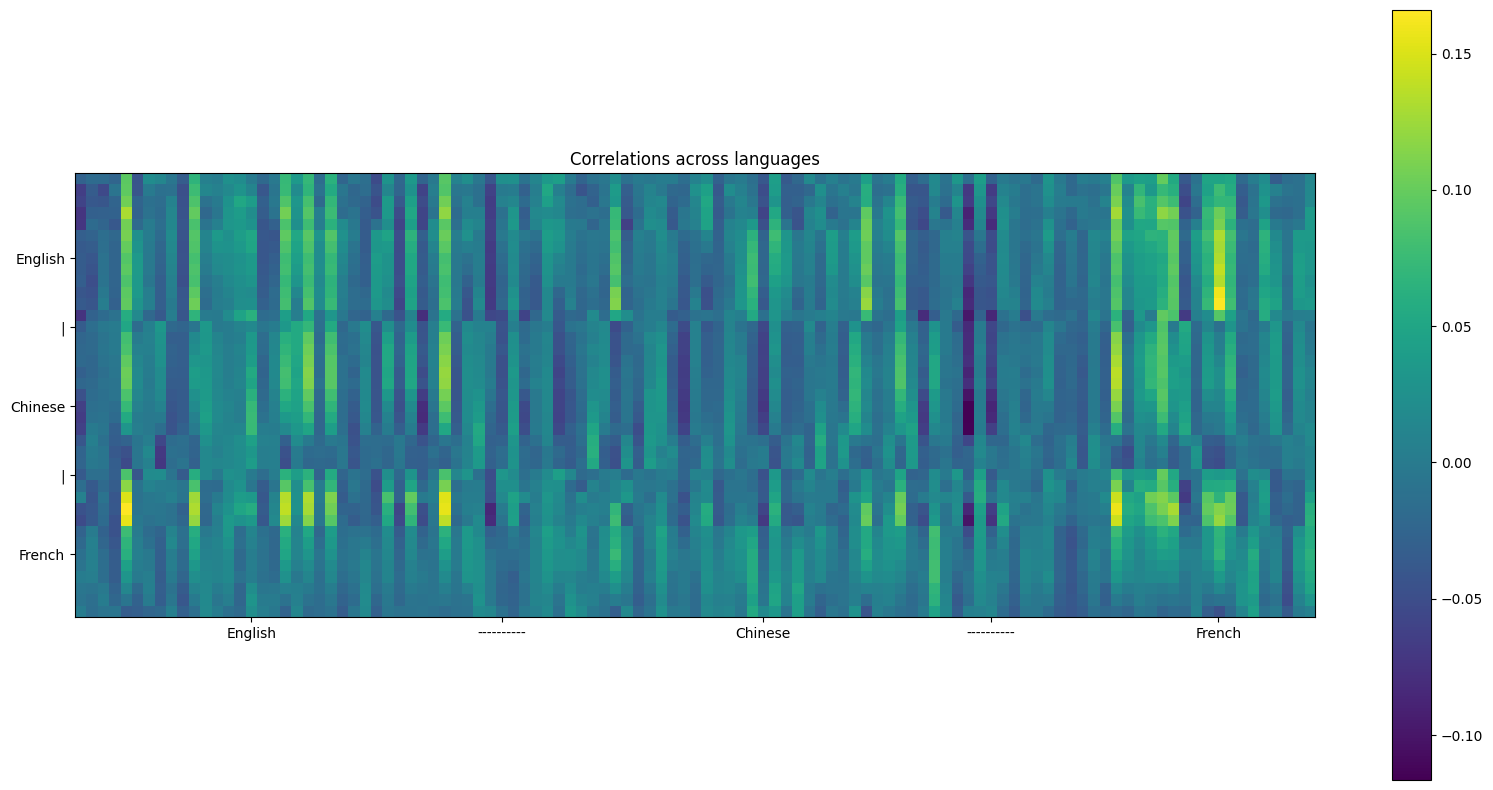

In [123]:
plt.figure(42, figsize=(20,10))
plt.title('Correlations across languages')
plt.yticks([7, 13, 20, 26, 33], ['English', '|', 'Chinese', '|', 'French'])
plt.xticks([15, 37, 60 ,80, 100], ['English', '----------', 'Chinese', '----------', 'French'])
plt.imshow(F_M_Correlations.T)
plt.colorbar()

## Aligning brain data

In [15]:
# text data
file_path = './text_data/EN_chunk_data_chunk_size_2.pickle'
with open(file_path, 'rb') as f:
    text_data = pickle.load(f)

In [16]:
text_data[0]

[{'sentences': 'once when i was six years old i saw a magnificent picture in a book about the primeval forest called real life stories. it showed a boa constrictor swallowing a wild animal. ',
  'onset': 0.113,
  'offset': 12.416,
  'section': 1},
 {'sentences': 'here is a copy of the drawing. it said in the book boa constrictors swallow their prey whole without chewing then they are not able to move and they sleep for the six months it takes for digestion. ',
  'onset': 13.144,
  'offset': 26.339,
  'section': 1},
 {'sentences': 'so i thought a lot about the adventures of the jungle and in turn i managed with a colored pencil to make my first drawing my drawing number one. it looked like this. ',
  'onset': 27.292,
  'offset': 38.326,
  'section': 1},
 {'sentences': 'i showed my masterpiece to the grownups and i asked them if my drawing frightened them. they answered me why would anyone be frightened by a hat. ',
  'onset': 39.608,
  'offset': 48.092,
  'section': 1},
 {'sentences': '

In [17]:
# hidden states
file_path = './text_data/EN_hidden_states_chunk_size_2.pickle'
with open(file_path, 'rb') as f:
    hidden_activations = pickle.load(f)

In [23]:
hidden_activations[0][0][0].shape

torch.Size([32, 76, 768])

In [9]:
# model rsas (140)
RSAs_models = RSAs_models

# brain rsas (140)
## load the dictionary from the JSON file
with open('./RSAs/RSAs_interpolated.json', 'r') as f:
    RSAs_list = json.load(f)

## convert the nested lists back to NumPy arrays
RSAs_fmri = {}
for key, value in RSAs_list.items():
    RSAs_fmri[key] = np.array(value)

## Correlations between FMRI and AI-models

In [11]:
print(RSAs_models.shape)
print(len(RSAs_fmri), RSAs_fmri['CN002'].shape)

(26, 140, 140)
109 (280, 280)


# 4. Other Analysis

## Trial Analysis

In [47]:
time_series_p1 = nii_data_1.transpose(3,0,1,2).reshape(nii_data_1.shape[3],-1)
print(time_series_p1.shape)
time_series_p2 = nii_data_2.transpose(3,0,1,2).reshape(nii_data_2.shape[3],-1)
print(time_series_p2.shape)

(282, 486180)
(282, 486180)


In [74]:
N = 10
transformed_time_series = []

for time_series_subj in [time_series_p1, time_series_p2]:

    pca = PCA(N)
    pca.fit(time_series_subj)
    print('Explained variance:', pca.explained_variance_ratio_)

    time_series_subj_pca = pca.transform(time_series_subj)
    time_series_subj_t = pca.inverse_transform(time_series_subj_pca)
    print(time_series_subj_t.shape)
    
    transformed_time_series.append(time_series_subj_t)

Explained variance: [0.11738748 0.10352329 0.09724053 0.06600865 0.04404133 0.03873402
 0.02957861 0.02763606 0.02074258 0.01873538]
(282, 486180)
Explained variance: [0.13900891 0.12934915 0.09585001 0.0581043  0.05315918 0.04618975
 0.03417909 0.03102534 0.02234069 0.02096533]
(282, 486180)


First get the mask

(282, 207632)

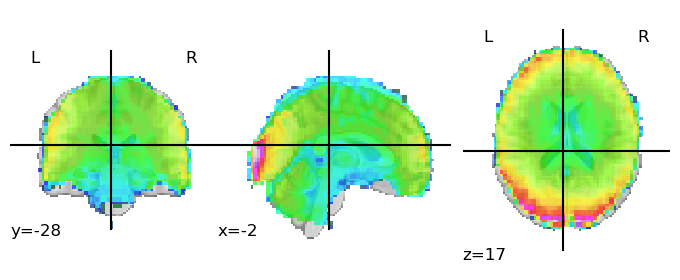

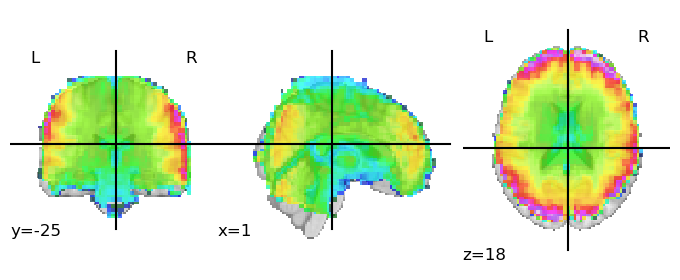

In [80]:
p1 = transformed_time_series[0]
p2 = transformed_time_series[1]

# Reshape the PCA-transformed data back into a 4D array
p1_4d = np.reshape(p1.T, nii_data_1.shape)

# Create a new Nifti image with the PCA-transformed data and the same header as the original image
p1_pca_img = new_img_like(nii_img_1, p1_4d, affine=nii_img_1.affine)

func_mean = image.mean_img(p1_pca_img)
display = plotting.plot_roi(func_mean)

func_mask = masking.compute_epi_mask(func_mean)
nii1_masked = masking.apply_mask(p1_pca_img, func_mask)
nii1_masked.shape

# Reshape the PCA-transformed data back into a 4D array
p2_4d = np.reshape(p2.T, nii_data_2.shape)

# Create a new Nifti image with the PCA-transformed data and the same header as the original image
p2_pca_img = new_img_like(nii_img_2, p2_4d, affine=nii_img_2.affine)

func_mean2 = image.mean_img(p2_pca_img)
display = plotting.plot_roi(func_mean2)

func_mask2 = masking.compute_epi_mask(func_mean2)
nii2_masked = masking.apply_mask(p2_pca_img, func_mask2)
nii2_masked.shape

## Brain Regions Analysis

[(1, 'Background'), (2, 'Frontal Pole'), (3, 'Insular Cortex'), (4, 'Superior Frontal Gyrus'), (5, 'Middle Frontal Gyrus'), (6, 'Inferior Frontal Gyrus, pars triangularis'), (7, 'Inferior Frontal Gyrus, pars opercularis'), (8, 'Precentral Gyrus'), (9, 'Temporal Pole'), (10, 'Superior Temporal Gyrus, anterior division'), (11, 'Superior Temporal Gyrus, posterior division'), (12, 'Middle Temporal Gyrus, anterior division'), (13, 'Middle Temporal Gyrus, posterior division'), (14, 'Middle Temporal Gyrus, temporooccipital part'), (15, 'Inferior Temporal Gyrus, anterior division'), (16, 'Inferior Temporal Gyrus, posterior division'), (17, 'Inferior Temporal Gyrus, temporooccipital part'), (18, 'Postcentral Gyrus'), (19, 'Superior Parietal Lobule'), (20, 'Supramarginal Gyrus, anterior division'), (21, 'Supramarginal Gyrus, posterior division'), (22, 'Angular Gyrus'), (23, 'Lateral Occipital Cortex, superior division'), (24, 'Lateral Occipital Cortex, inferior division'), (25, 'Intracalcarine C

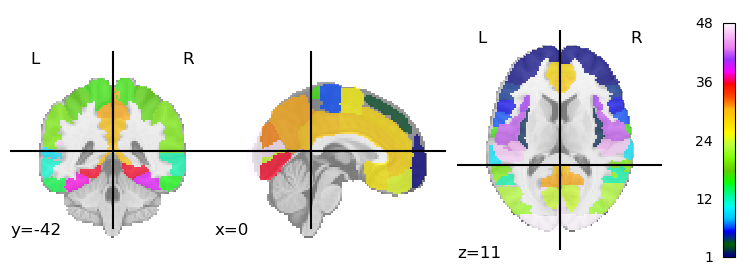

In [81]:
ho_maxprob_atlas = datasets.fetch_atlas_harvard_oxford('cort-maxprob-thr25-2mm')
ho_maxprob_atlas_img = image.load_img(ho_maxprob_atlas['maps'])

# ROI numbers & text labels in this atlas
print([(i+1, roi) for i, roi in enumerate(ho_maxprob_atlas['labels'])])
display = plotting.plot_roi(ho_maxprob_atlas_img, colorbar=True)

In [83]:
# resample the atlas to the dataset resolution
ho_maxprob_atlas_img_resamp1 = image.resample_to_img(
    ho_maxprob_atlas_img,
    target_img=p1_pca_img,
    interpolation='nearest'
)
ho_maxprob_atlas_img_resamp2 = image.resample_to_img(
    ho_maxprob_atlas_img,
    target_img=p2_pca_img,
    interpolation='nearest'
)

In [85]:
# reduce data to get mean signal for each ROI
av_roi_data1 = regions.img_to_signals_labels(
    p1_pca_img,
    labels_img=ho_maxprob_atlas_img_resamp1,
    background_label=0
)
av_roi_data2 = regions.img_to_signals_labels(
    p2_pca_img,
    labels_img=ho_maxprob_atlas_img_resamp2,
    background_label=0
)

In [87]:
print(av_roi_data1[0].shape)
print(av_roi_data2[0].shape)

(282, 48)
(282, 48)
